In [1]:
from skimage.morphology import convex_hull_image, binary_closing, square, dilation
from PIL import Image, ImageDraw, ImageFont
from matplotlib.pyplot import imshow
import matplotlib.pyplot as plt
from scipy import ndimage
from tqdm import tqdm
import pandas as pd
import numpy as np
import cv2
import os

In [2]:
#  load all images from a directory
def load_images_from_folder(folder):
    images = []
    filenames = []
    for filename in tqdm(os.listdir(folder)):
        try:
            img = Image.open(os.path.join(folder,filename))
            if img is not None:
                if img.mode != 'RGB':
                    img = img.convert('RGB')
                img = np.array(img)
                images.append(img)
                filenames.append(filename)
        except Exception as e:
            print(e)
    return images, filenames

In [3]:
# load all jsons from a directory
def load_jsons_from_folder(folder):
    jsons = []
    filenames = []
    for filename in tqdm(os.listdir(folder)):
        try:
            json = pd.read_json(os.path.join(folder,filename))
            if json is not None:
                jsons.append(json)
                filenames.append(filename)
        except Exception as e:
            print(e)
    return jsons, filenames

In [4]:
LOAD_CLEAN = False
if LOAD_CLEAN:
    human_parsing = load_images_from_folder('Task/dataset/human_parsing')
    image = load_images_from_folder('Task/dataset/image')
    pose_json = load_jsons_from_folder('Task/dataset/pose_json')
    pose_img = load_images_from_folder('Task/dataset/pose_img')
    df = pd.DataFrame()
    df['human_parsing'] = human_parsing[0]
    df['image'] = image[0]
    df['pose_json'] = pose_json[0]
    df['pose_img'] = pose_img[0]
    df['ids'] = [a.split('.')[0] for a in image[1]]
    df['pose_keypoints'] = df.pose_json.apply(lambda x: x.people[0].get('pose_keypoints_2d'))
    left_ankles = [a[3*11:3*12-1] for a in tqdm(df.pose_keypoints)]
    right_ankles = [a[3*14:3*15-1] for a in tqdm(df.pose_keypoints)]
    df['left_ankles'] = left_ankles
    df['right_ankles'] = right_ankles
    df.to_pickle('df.pkl')
else:
    df = pd.read_pickle('df.pkl')

  1%|▏         | 10/705 [00:00<00:13, 50.30it/s]

cannot identify image file 'Task/dataset/image\\.DS_Store'


100%|██████████| 704/704 [00:00<00:00, 705565.12it/s]


In [27]:
def get_color_mask(img, colors):
    mask = np.zeros(img.shape[:2], dtype=np.uint8)
    for color in colors:
        mask += np.all(img == color, axis=-1).astype(np.uint8)
    return mask

def clean_outliers(mask):
    labels, num_labels = ndimage.label(mask)
    component_sizes = ndimage.sum(mask, labels, range(num_labels + 1))
    mask_largest_component = (labels == component_sizes.argmax())
    return mask_largest_component

def apply_mask(img, mask):
    img = np.array(img)
    img[mask] = (128, 128, 128)
    return Image.fromarray(img)

def ankle_mask(img, left_ankle, right_ankle):
    try:
        img = np.array(img)
        mask = np.zeros(img.shape[:2], dtype=np.uint8)
        x = [left_ankle[0], right_ankle[0]]
        y = [left_ankle[1], right_ankle[1]]
        m = (y[1] - y[0]) / (x[1] - x[0])
        b = y[0] - m * x[0]
        for i in range(img.shape[0]):
            for j in range(img.shape[1]):
                if i > m * j + b:
                    mask[i, j] = 1
        return mask
    except Exception as e:
        print(e)
        return np.zeros(img.shape[:2], dtype=np.uint8)

In [5]:
short_colors = {(64, 0, 128), (192, 0, 0)}
legs_colors = {(128,64,0), (0,64,0)}

shirt_colors = {(128,0,128), (128,128,128), (128,64,128)}
hands_colors = {(192,128,128),(64,128,128)}

In [32]:
RENDER = False
if RENDER:
    tqdm._instances.clear()
    mask_shorts = [get_color_mask(a, short_colors) for a in tqdm(human_parsing[0])]
    mask_legs = [get_color_mask(a, legs_colors) for a in tqdm(human_parsing[0])]
    # mask_legs_and_shorts = [np.logical_or(a, b) for a, b in tqdm(zip(mask_shorts, mask_legs))]

    mask_shirts = [get_color_mask(a, shirt_colors) for a in tqdm(human_parsing[0])]
    mask_hands = [get_color_mask(a, hands_colors) for a in tqdm(human_parsing[0])]
    # mask_upper_body = [np.logical_or(a, b) for a, b in tqdm(zip(mask_shirts, mask_hands))]
    # mask_upper_body_clean = [clean_outliers(a) for a in tqdm(mask_upper_body)]

    mask_skirts_clean = [np.logical_and(a, np.logical_not(b)) for a, b in tqdm(zip(mask_legs_and_shorts, mask_upper_body_clean))]
    mask_skirts_clean_no_outliers = [clean_outliers(a) for a in tqdm(mask_skirts_clean)]
    mask_skirts_clean_convex = [convex_hull_image(a) for a in tqdm(mask_skirts_clean_no_outliers)]
    mask_skirts_final = [np.logical_and(a, np.logical_not(b)) for a, b in tqdm(zip(mask_skirts_clean_convex, mask_upper_body_clean))]

    mask_ankle = [ankle_mask(a, b, c) for a, b, c in tqdm(zip(df.image, df.left_ankles, df.right_ankles))]

    processed_images = [apply_mask(a, b) for a, b in tqdm(zip(df.image, mask_skirts_final))]

    mask_skirt_withankles = []
    for a, b in tqdm(zip(mask_skirts_final, mask_ankle)):
        if b.any():
            mask_skirt_withankles.append(np.logical_and(a, np.logical_not(b)))
        else:
            mask_skirt_withankles.append(a)

    processed_images_withankles = [apply_mask(a, b) for a, b in tqdm(zip(df.image, mask_skirt_withankles))]

    
    df['mask_shorts'] = mask_shorts
    df['mask_legs'] = mask_legs
    df['mask_shirts'] = mask_shirts
    df['mask_hands'] = mask_hands


    df['mask_legs_and_shorts'] = mask_legs_and_shorts
    df['mask_upper_body'] = mask_upper_body
    df['mask_skirts_clean'] = mask_skirts_clean
    df['mask_skirts_clean_no_outliers'] = mask_skirts_clean_no_outliers
    df['mask_skirts_clean_convex'] = mask_skirts_clean_convex
    df['mask_skirts_final'] = mask_skirts_final

    df['mask_ankle'] = mask_ankle

    df['processed_images'] = processed_images
    df['processed_images_ankles'] = processed_images_withankles
    df.to_pickle('df_full.pkl')
else:
    df = pd.read_pickle('df_full.pkl')

704it [00:01, 530.05it/s]
704it [00:06, 104.99it/s]


In [33]:
# save processed_images to /preprocessed
SAVE_PROCESSED = True
if SAVE_PROCESSED:
    for i, img in tqdm(enumerate(processed_images_withankles)):
        img.save('C:/code/python/test_task_big/preprocessed_6/' + df.ids[i] + '.jpg')

704it [00:08, 87.11it/s] 


In [10]:
img_cols = set(df.columns) - set(['ids', 'pose_keypoints', 'pose_json'])
img_cols = [
    'image',
    'human_parsing',
    'pose_img',
    'mask_shorts',
    'mask_legs',
    'mask_legs_and_shorts',
    'mask_shirts',
    'mask_hands',
    'mask_upper_body',
    'mask_skirts_clean',
    'mask_skirts_clean_no_outliers',
    'mask_skirts_clean_convex',
    'mask_skirts_final',
    'mask_ankle'
    'processed_images',
    'processed_images_ankles'
 ]

In [11]:
def show_images_df(df, cols, index):
    fig, axes = plt.subplots(1, len(cols), figsize=(20, 20))
    for i, col in enumerate(cols):
        axes[i].imshow(df[col][index])
        axes[i].set_title(col)
    plt.show()
    # save image
    fig.savefig('full_outs/' + df.ids[index] + '.jpg')

In [49]:
img_cols = ['mask_ankle', 'processed_images', 'processed_images_ankles', 'mask_shorts', 'human_parsing', 'mask_skirts_clean', 'mask_skirts_clean_no_outliers']

In [54]:
df[df.ids.str.contains('48366')].index

Int64Index([235], dtype='int64')

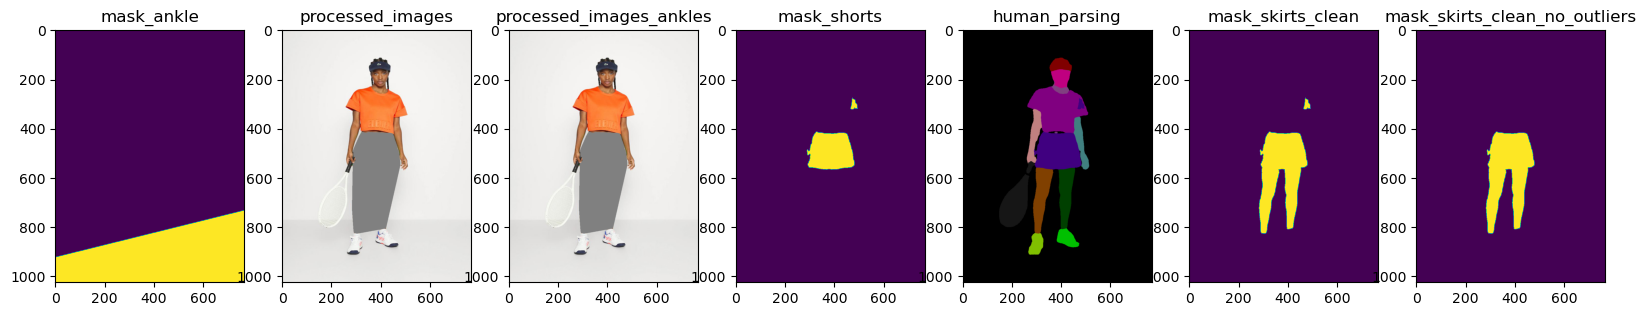

In [55]:
show_images_df(df, img_cols, 235)

In [1]:
df.mask_shorts[235]


NameError: name 'df' is not defined

In [13]:
# HELPER FUNCTIONS
# def draw_pose(img, poses):
#     draw = ImageDraw.Draw(img)
#     for i in range(0, len(poses), 3):
#         draw.ellipse((poses[i]-5, poses[i+1]-5, poses[i]+5, poses[i+1]+5), fill=(255, 0, 0, 255))
#         draw.text((poses[i], poses[i+1]), str(i//3), fill=(255, 0, 0, 0), font= ImageFont.truetype("arial.ttf", 30))
#     return img
# draw_pose(df.image[0], df.pose_keypoints[0])

